In [1]:
!pip install -U kaleido
import kaleido
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
import base64
import io
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:

df = pd.read_csv('fortune500.csv')

df = df[(df['Year'] >= 2000) & (df['Year'] <= 2020)]
df['Name'] = df['Name'].replace('Google', 'Alphabet')
big_tech_names = ['Apple', 'Microsoft', 'Amazon', 'Alphabet', 'Facebook']
big_tech_all_years = df[df['Name'].isin(big_tech_names)]

df['Revenue'] = pd.to_numeric(df['Revenue'], errors='coerce')
top_10_by_year = df.groupby('Year').apply(lambda x: x.nlargest(10, 'Revenue')).reset_index(drop=True)
total_revenue_top_10 = top_10_by_year.groupby('Year')['Revenue'].sum().reset_index()
total_revenue_top_10.columns = ['Year', 'Total_Revenue_Top_10']

big_tech_all_years = big_tech_all_years.merge(total_revenue_top_10, on='Year', how='left')

big_tech_all_years.to_csv('fortune500_with_top_10_total_revenue.csv', index=False)


In [3]:
big_tech_all_years

,Year,Name,Revenue,Rank,Total_Revenue_Top_10
0,2020,Amazon,280522,2,2658246.1
1,2020,Apple,260174,4,2658246.1
2,2020,Alphabet,161857,11,2658246.1
3,2020,Microsoft,125843,21,2658246.1
4,2020,Facebook,70697,46,2658246.1
...,...,...,...,...,...
79,2002,Amazon,3122.4,492,1386227.0
80,2001,Microsoft,22956,79,1330469.0
81,2001,Apple,7983,236,1330469.0
82,2000,Microsoft,19747,84,1145624.0


In [3]:
#The file 'fortune500_with_top_10_total_revenue.csv' has been checked and missing data has been added from the Fortune 500 web site.
#This resulted in the fortune500_with_top_10_total_revenue_fixed.csv file

In [5]:
data = pd.read_csv('fortune500_with_top_10_total_revenue_fixed.csv')

logos = {
    'Alphabet': 'alphabet_logo.png',
    'Amazon': 'amazon_logo.png',
    'Apple': 'apple_logo.png',
    'Facebook': 'facebook_logo.png',
    'Microsoft': 'microsoft_logo.png'
}

for key, value in logos.items():
    with open(value, 'rb') as f:
        image = Image.open(f)
        buffered = io.BytesIO()
        image.save(buffered, format='PNG')
        encoded_image = base64.b64encode(buffered.getvalue()).decode('utf-8')
        logos[key] = f'data:image/png;base64,{encoded_image}'

data['Revenue'] = pd.to_numeric(data['Revenue'], errors='coerce')
data['Total_Revenue'] = data['Total_Revenue_Top_10']
data['Total_Revenue'] = pd.to_numeric(data['Total_Revenue'], errors='coerce')

data['Revenue_Percentage'] = data['Revenue'] / data['Total_Revenue']
pivot_table = data.pivot_table(index='Year', columns='Name', values='Revenue_Percentage', aggfunc='sum')

years = pivot_table.index.unique()
ordered_firms = ['Amazon', 'Apple', 'Alphabet', 'Microsoft', 'Facebook']
all_firms = ordered_firms
multiindex = pd.MultiIndex.from_product([years, all_firms], names=['Year', 'Name'])
all_combinations_df = pd.DataFrame(index=multiindex).reset_index()

pivot_table = pivot_table.reset_index().rename_axis(None, axis=1).melt(id_vars=['Year'], var_name='Name', value_name='Revenue_Percentage')

stacked_data = all_combinations_df.merge(pivot_table, on=['Year', 'Name'], how='left').fillna(0)
stacked_data = all_combinations_df.merge(pivot_table.reset_index(), on=['Year', 'Name'], how='left').fillna(0)
stacked_data = pivot_table.rename(columns={0: 'Revenue_Percentage'})


# Create a dictionary to map firm names to the custom order
firm_order_mapping = {firm: order for order, firm in enumerate(ordered_firms)}
stacked_data['Firm_Order'] = stacked_data['Name'].map(firm_order_mapping)
stacked_data = stacked_data.sort_values(by=['Year', 'Firm_Order'])



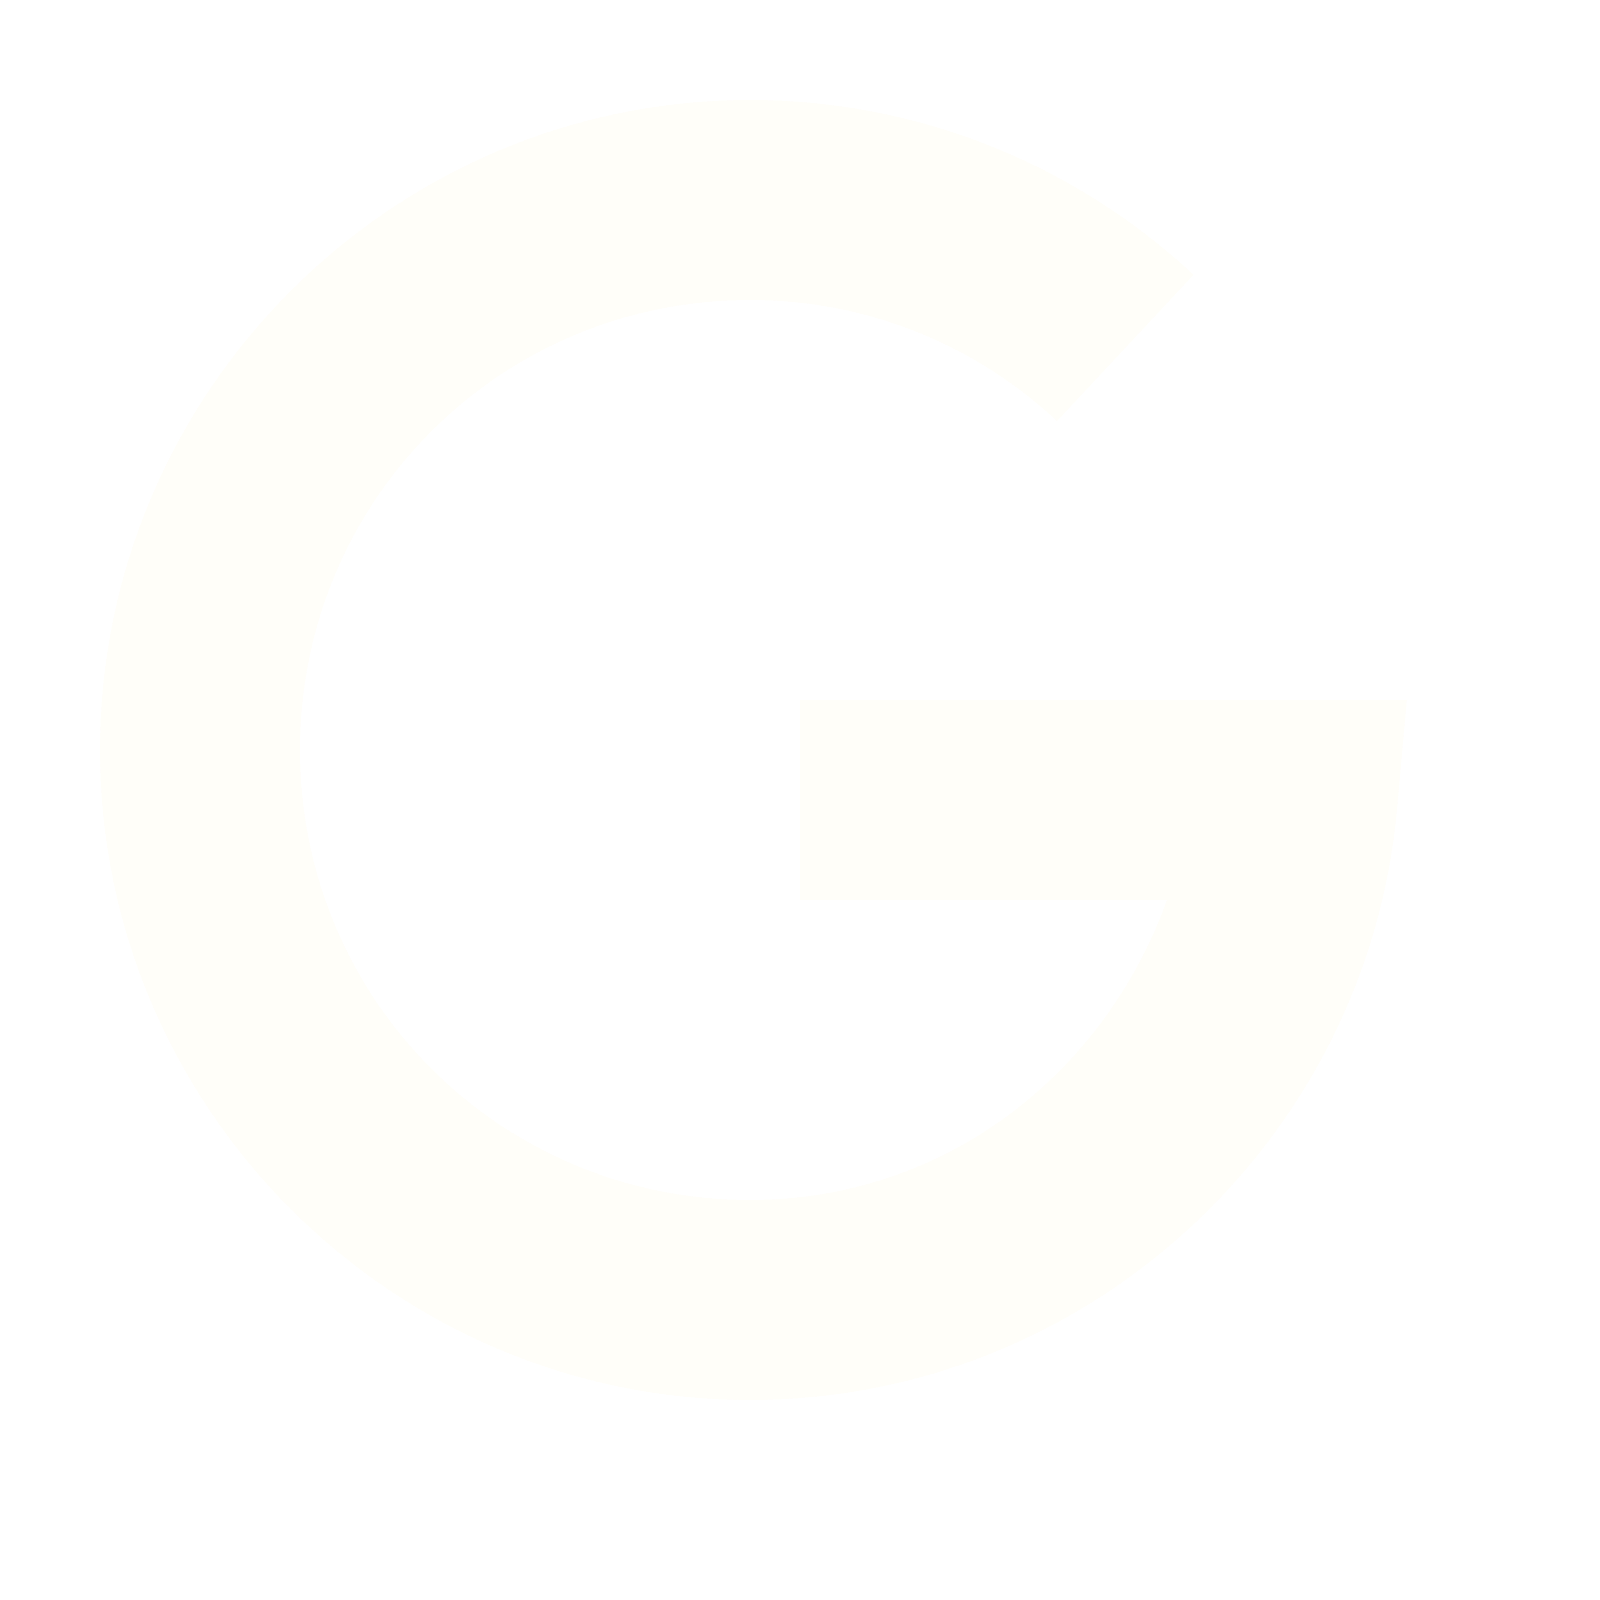
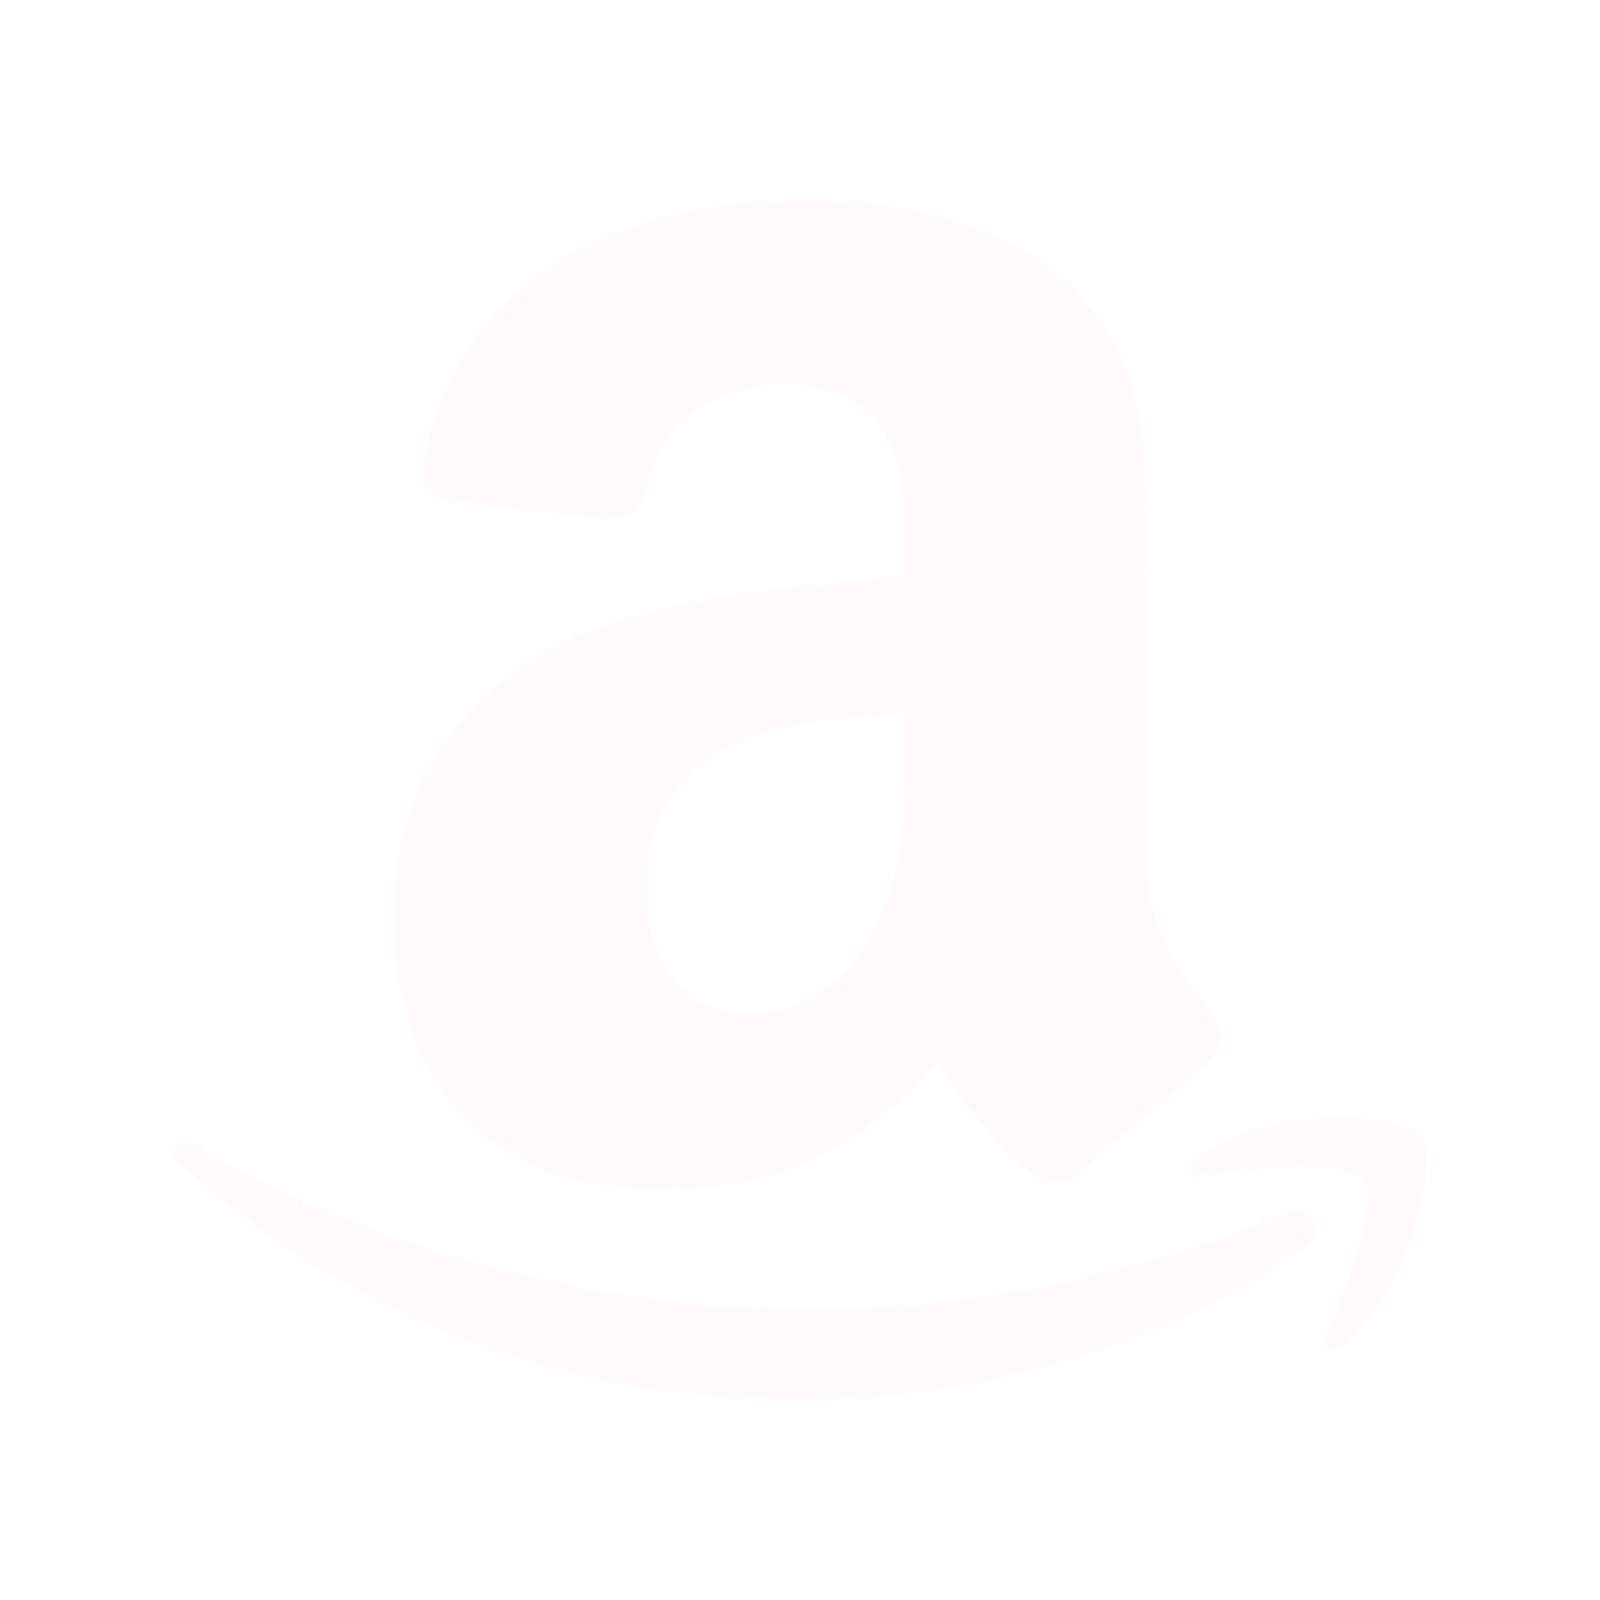
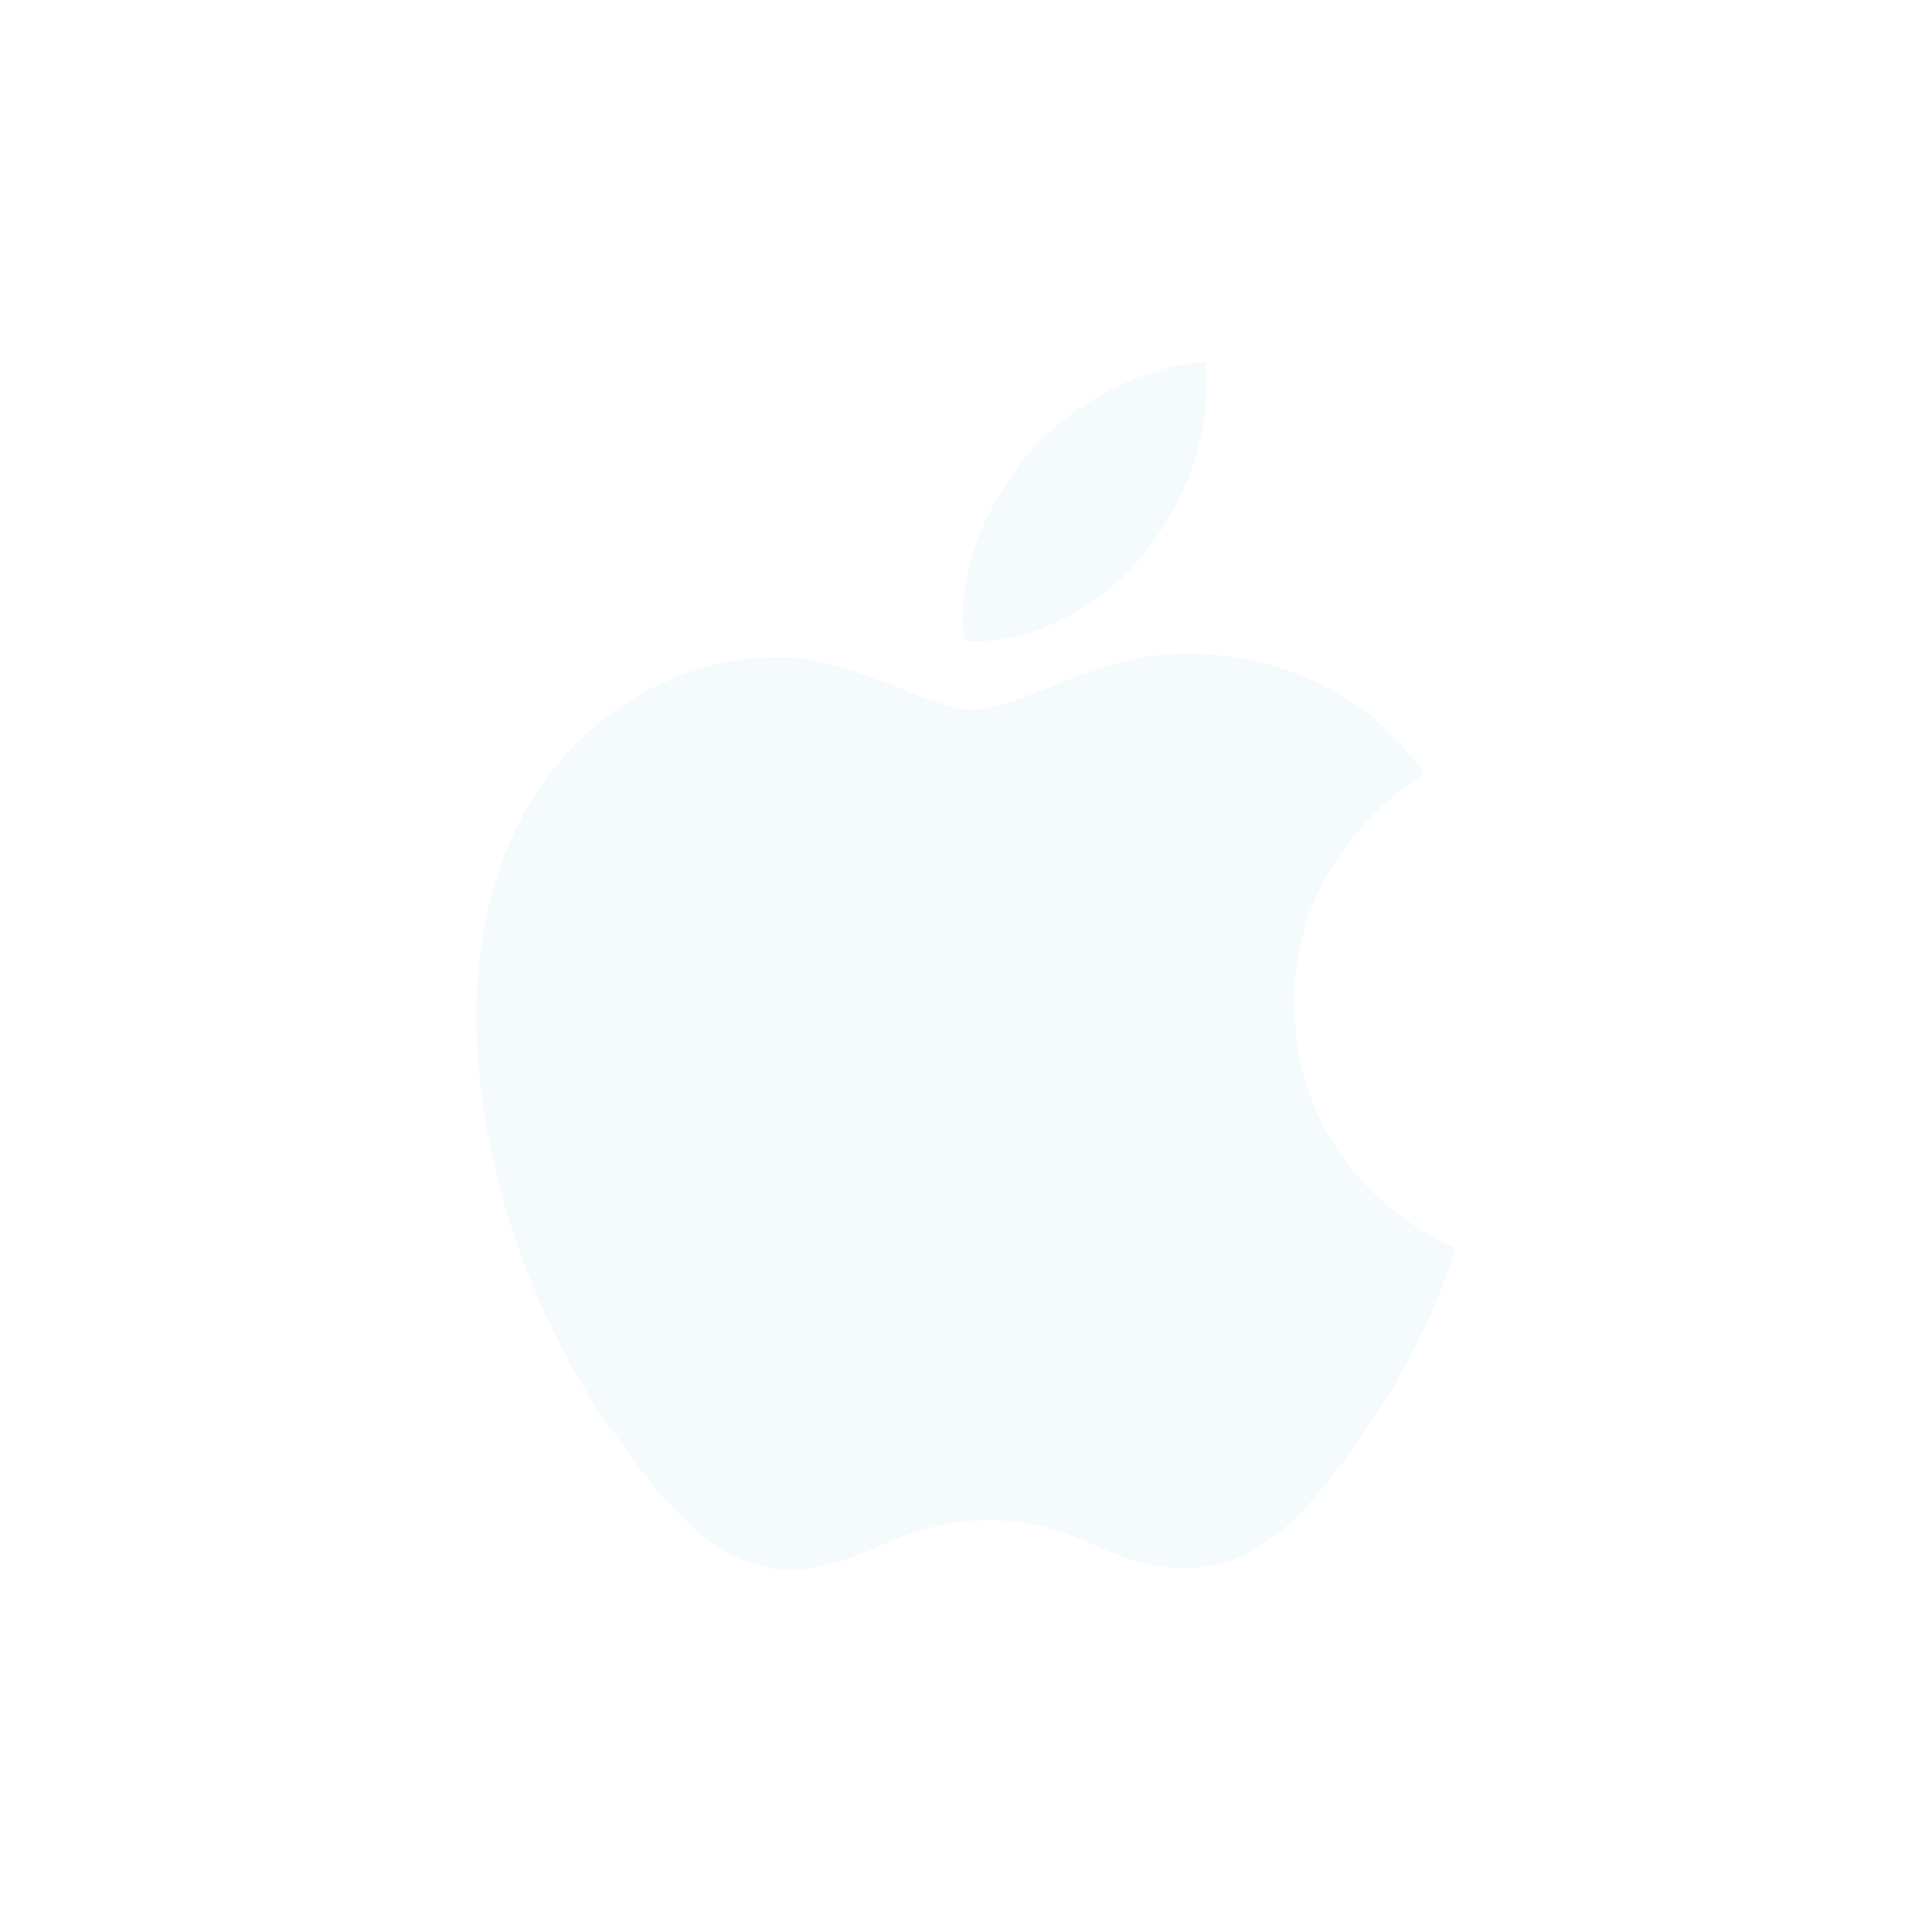
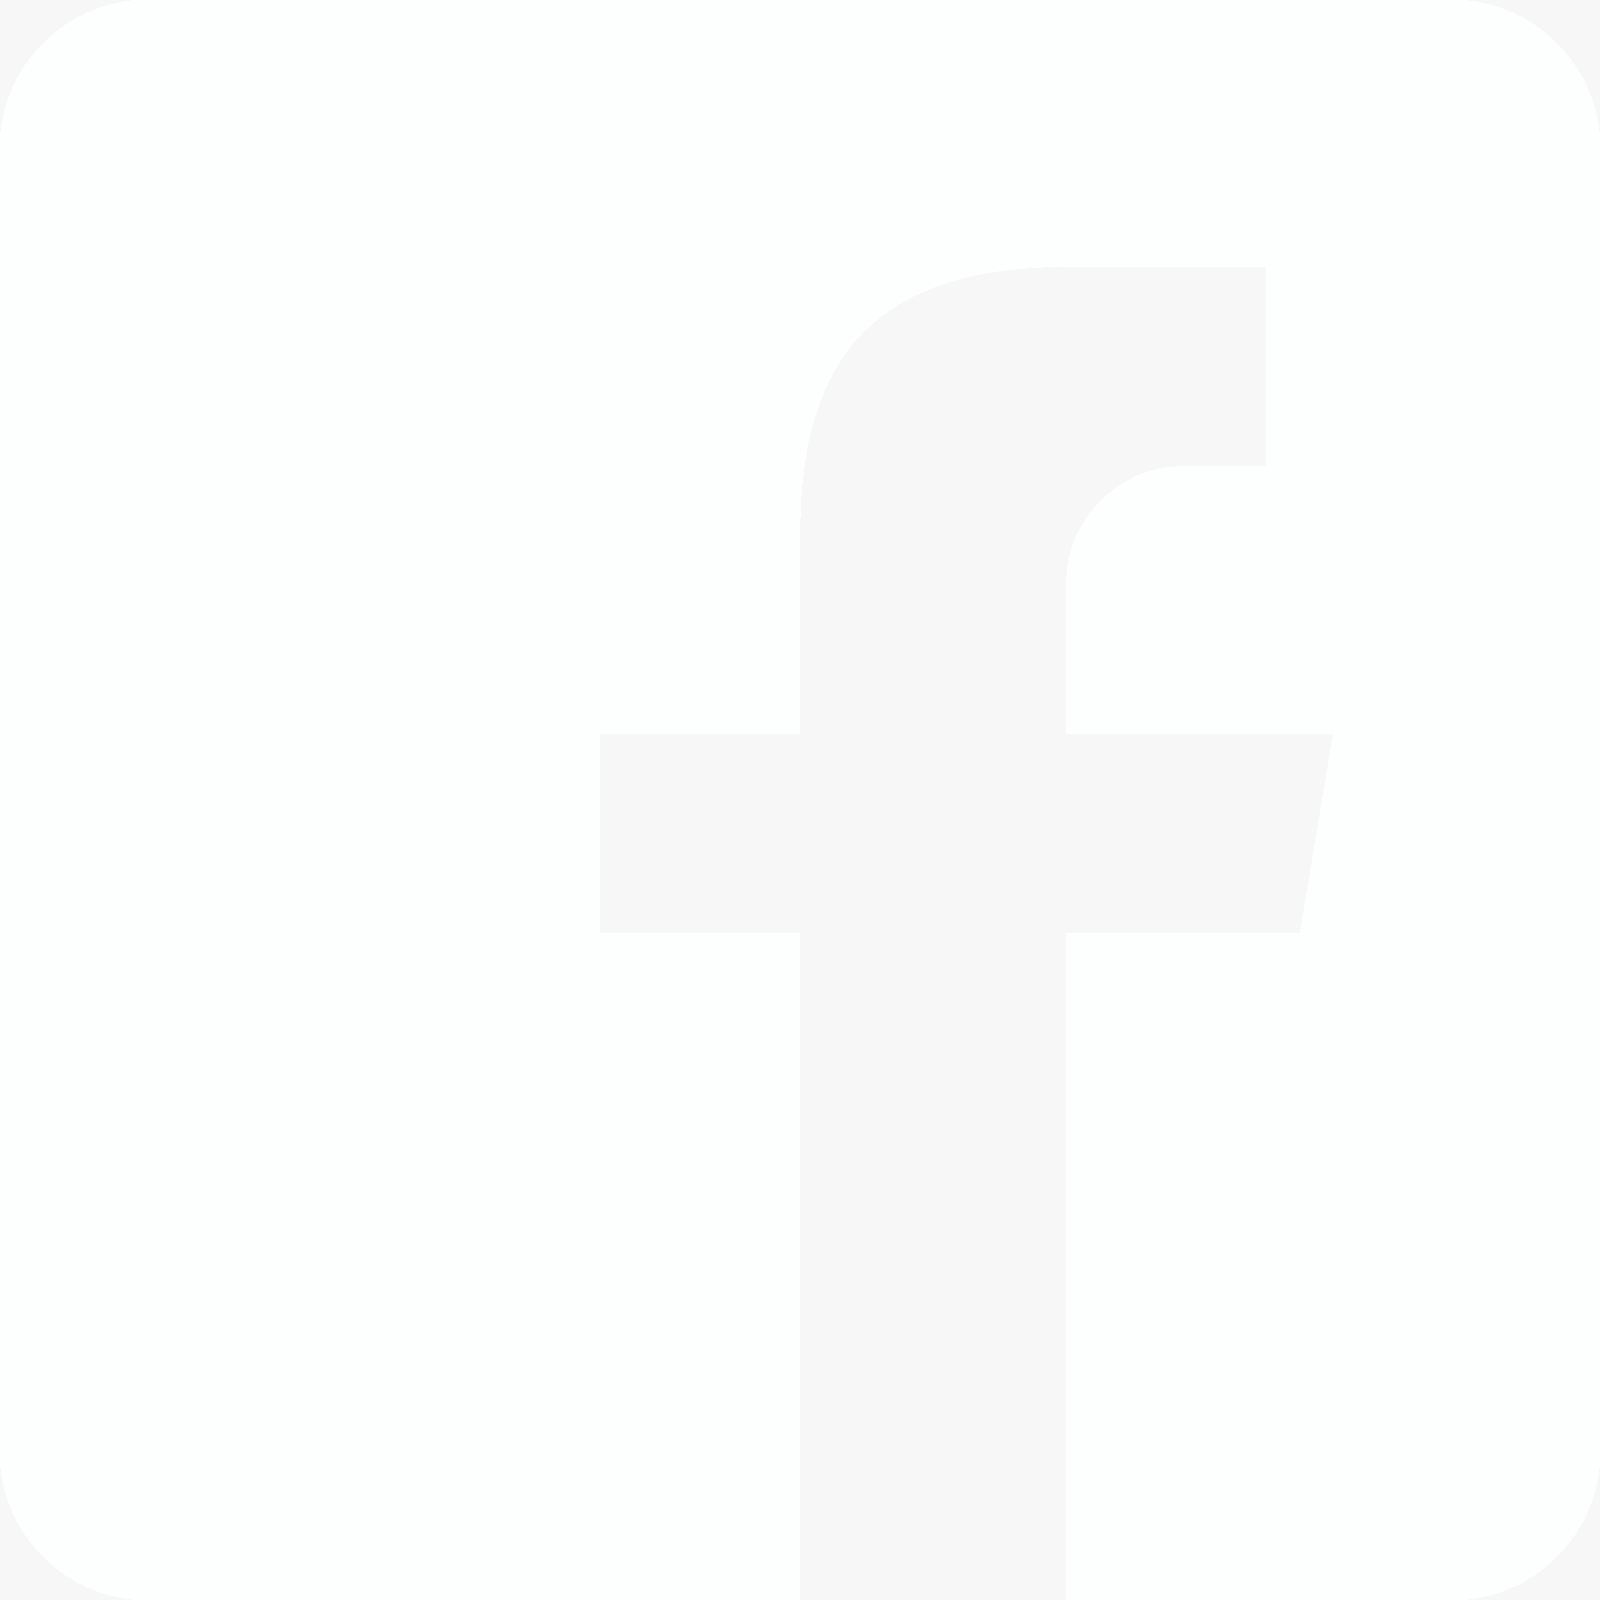
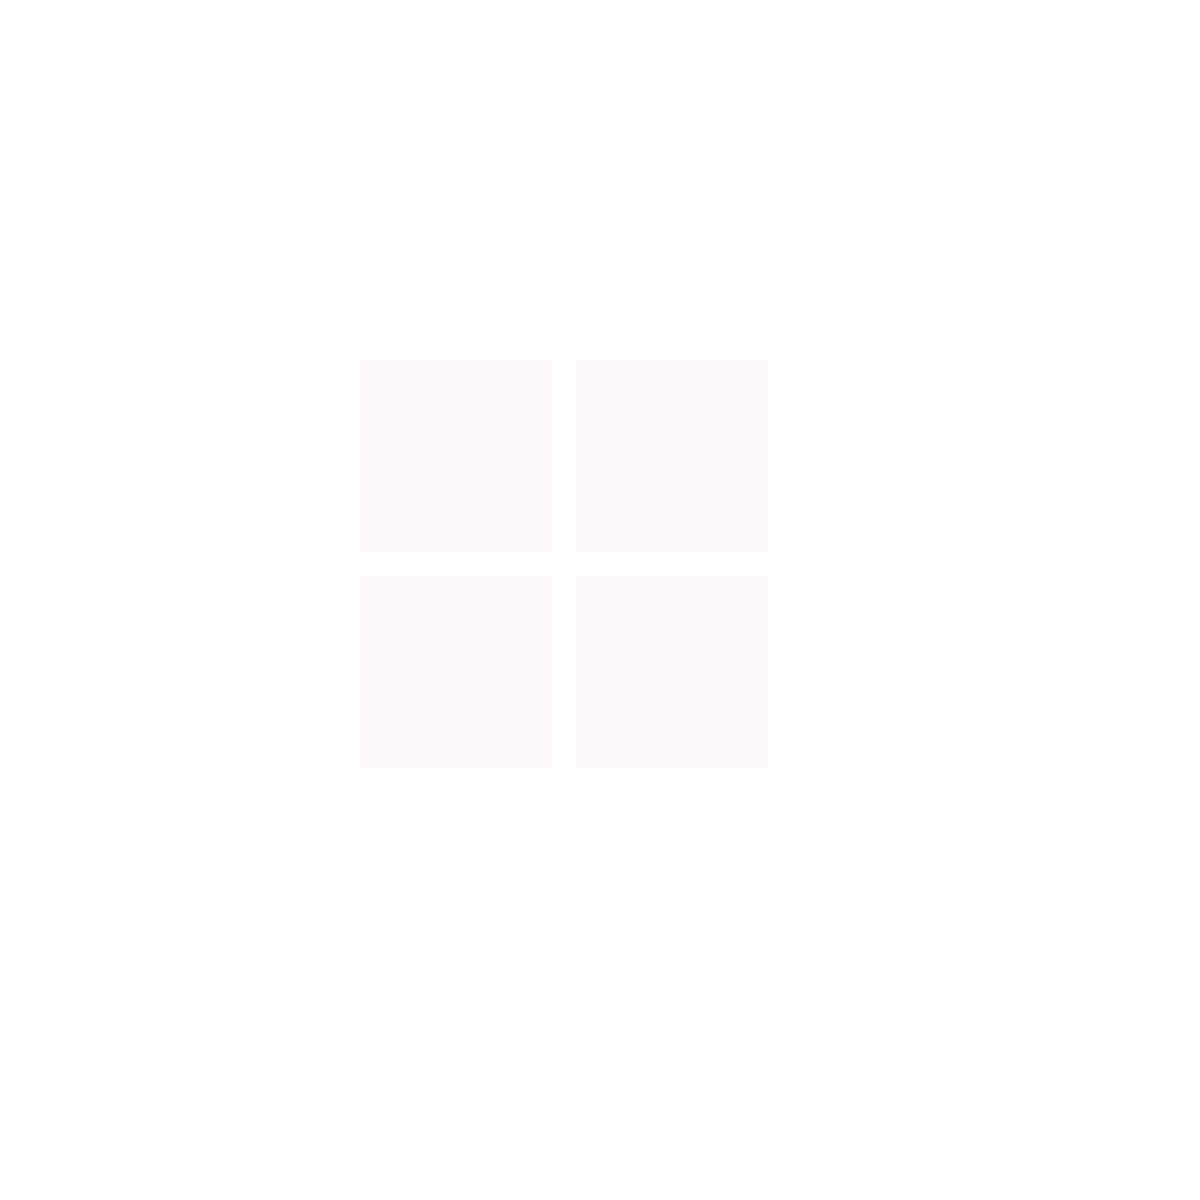

In [6]:
#1st visualisation
fig = go.Figure()

# Add traces for each tech company
for company, fillcolor in zip(['Amazon', 'Apple', 'Alphabet', 'Microsoft', 'Facebook'],
                              ['rgba(255, 153, 0, 1)', 'rgba(97, 187, 70, 1)', 'rgba(237, 28, 36, 1)', 'rgba(0, 164, 239, 1)', 'rgba(0, 128, 251, 1)']):
    fig.add_trace(go.Scatter(x=stacked_data[stacked_data['Name'] == company]['Year'],
                             y=stacked_data[stacked_data['Name'] == company]['Revenue_Percentage'],
                             name=company,
                             fill='tonexty',
                             mode='lines',
                             fillcolor=fillcolor,
                             line=dict(width=0.5, color='Grey'),
                             stackgroup='one'))

# Add company logos
images_list = [
    dict(source=logos[company], xref='paper', yref='paper', x=x, y=y, sizex=sx, sizey=sy, xanchor='left', yanchor='bottom')
    for company, x, y, sx, sy in zip(['Alphabet', 'Amazon', 'Apple', 'Facebook', 'Microsoft'],
                                     [1.018, 1.018, 1.018, 1.0195, 0.9814],
                                     [0.54, 0.1, 0.35, 0.8, 0.6],
                                     [0.1, 0.1, 0.1, 0.08, 0.23],
                                     [0.1, 0.1, 0.1, 0.08, 0.23])
]

# Update layout
fig.update_layout(
    title="The Rise of Big Tech",
    title_x=0.023,
    title_y=0.975,
    title_xanchor="left",
    title_yanchor="top",
    font=dict(size=24),
    showlegend=True,
    xaxis=dict(tickmode='linear', dtick=5, tickformat='.0f', showgrid=False, tickfont=dict(size=16)),
    yaxis=dict(tickformat='.0%', range=[0, 0.4], dtick=0.1, showgrid=True, gridcolor='Lightgrey', gridwidth=1, tickfont=dict(size=16)),
    plot_bgcolor='rgba(0,0,0,0)',
    width=1200,
    height=900,
    images=images_list,
    margin=dict(l=50, r=100, b=100, t=200, pad=4),
    legend=dict(orientation="h", yanchor="bottom", y=1.1, xanchor="left", x=-0.03, font=dict(size=16)),
    shapes=[dict(type="line", x0=0, x1=1, y0=1, y1=1, yref="paper", xref="paper", line=dict(color="Lightgrey", width=1))],
    annotations=[dict(text="U.S. Tech Giants: Their Slice of the Top 10 Fortune 500 Sales Pie",
                      x=-0.025, y=1.225, xref="paper", yref="paper", showarrow=False, font=dict(size=20, color="White"), xanchor="left", yanchor="top")]
)

# Add iPhone release annotation
iphone_release_year = 2007.583
fig.add_shape(
    type='line',
    x0=iphone_release_year,
    x1=iphone_release_year,
    y0=0,
    y1=1.05,
    yref='paper',
    xref='x',
    line=dict(color='Grey', width=1),
)

fig.add_annotation(
    x=2006,
    y=0.25,
    xref="x",
    yref="y",
    text="iPhone Release<br>A New Era Begins<br>in 2007",
    showarrow=False,
    font=dict(size=14, color="White")
)

# Add percentage annotation
annotation_x = 2020
annotation_y = 0.37 
fig.add_annotation(
    text="     35%<br>in 2020",
    x=annotation_x,
    y=annotation_y,
    xref='x',
    yref='y',
    showarrow=False,
    font=dict(size=18, color="White"),
    xanchor='right'
)

# Add source annotation
fig.add_annotation(text="Source: Fortune 500, published by Fortune Magazine",
                                 xref="paper", yref="paper",
                                 xanchor="left", yanchor="bottom",
                                 x=-0.02, y=-0.15,
                                 showarrow=False,
                                 font=dict(size=14, color='Lightgrey'))

# Apply dark template
fig.update_layout(
  template="plotly_dark"
)
fig.show()



In [5]:
#Checking which firms dropped the most in rating

In [16]:
big_5_tech = ['Apple', 'Microsoft', 'Amazon', 'Alphabet', 'Facebook']
filtered_df_2006 = df[(df['Year'] == 2006) & (df['Name'].isin(big_5_tech))]
filtered_df_2020 = df[(df['Year'] == 2020) & (df['Name'].isin(big_5_tech))]
big_5_rank_df = pd.concat([filtered_df_2006, filtered_df_2020])

df_2006 = df[df['Year'] == 2006]
df_2020 = df[df['Year'] == 2020]
merged_df = df_2006.merge(df_2020, on='Name', suffixes=('_2006', '_2020'))
merged_df['rank_diff'] = merged_df['Rank_2020'] - merged_df['Rank_2006']
top_dropped_rank = merged_df.nlargest(20, 'rank_diff')[['Name', 'Rank_2006', 'Rank_2020']]

top_10_2005 = df[df['Year'] == 2006].nsmallest(10, 'Rank')
top_10_2005_names = top_10_2005['Name'].tolist()
filtered_df_2020 = df[(df['Year'] == 2020) & (df['Name'].isin(top_10_2005_names))]
merged_top_10 = top_10_2005.merge(filtered_df_2020, on='Name', suffixes=('_2006', '_2020'))
df_top = merged_top_10[['Name', 'Rank_2006', 'Rank_2020']]

print(top_dropped_rank)
print(df_top)

                                   Name  Rank_2006  Rank_2020
67                         Weyerhaeuser         90        457
44                             Motorola         54        403
65                                 News         86        318
60                                Alcoa         79        302
119                            Huntsman        172        382
121                               Masco        174        384
124                            Williams        180        387
167                      R.H. Donnelley        265        471
99                                Xerox        142        347
145                          Dean Foods        216        421
147                        Devon Energy        219        419
178                      First American        284        476
190                      Fortune Brands        305        494
179  Science Applications International        285        466
184                           Dillard's        294        468
87      

In [7]:
#Based on these findings, manually created a new dataset, displaying change in rank for key firms: change_2006_2020.csv

In [7]:
#Creating 2nd chart


def plot_slope_chart(df, x1_col, x2_col, y_col, title, subtitle, xlabel, ylabel):

    fig, ax = plt.subplots(figsize=(4, 6))
    fig.set_facecolor('#141014')

    for index, row in df.iterrows():
        if row[y_col] in ['Apple', 'Amazon', 'Alphabet', 'IBM', 'AIG', 'Conoco']:
            x_values = [1, 2]
            y_values = [row[x1_col], row[x2_col]]
            
            if row[y_col] in ['Apple', 'Amazon', 'Alphabet']:
                line_color = 'forestgreen'
            else:
                line_color = 'mediumvioletred'
            
            ax.plot(x_values, y_values, marker='o', linestyle='-', markerfacecolor='#090619', markeredgewidth=1, color=line_color)
            
            y_offset = 0
            if row[y_col] == 'Alphabet':
                y_offset = 6
            elif row[y_col] == 'Amazon':
                y_offset = -10
            
            # Display firm name next to the right point for specific companies
            text = ax.text(2.05, row[x2_col] + y_offset, row[y_col], fontsize=10, va='center', color=line_color)
    

    ax.set_facecolor('#141014')

    ax.set_xticks([1, 2])
    ax.set_xticklabels(['2006', '2020'])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title,x = 0.55, y = 1.1, fontsize = 12, color='white', ha='right')
    ax.text(-0.075,1.07, subtitle, transform=ax.transAxes, fontsize=10, ha='left', va='center', color = 'white')
    
    # Invert the y-axis
    ax.invert_yaxis()
    
    # Set grid lines at 50 increments of rank
    ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.grid(axis='y', linestyle='--', color='white')
    ax.tick_params(axis='both', colors='white')

    # Set tick colors to grey
    ax.tick_params(axis='both')
    
    # Remove border on the sides, keep only top and bottom border
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom']
    
    plt.savefig('matplotlib_chart.png', bbox_inches='tight', dpi = 175)
    plt.show()




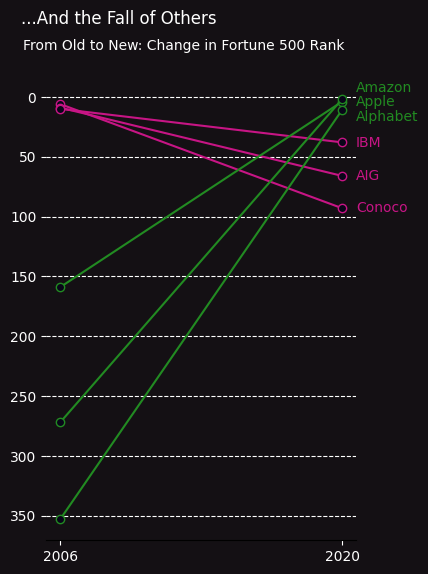

In [8]:
df_top = pd.read_csv("change_2006_2020.csv")
plot_slope_chart(df_top, 'Rank_2006', 'Rank_2020', 'Name', '...And the Fall of Others', 'From Old to New: Change in Fortune 500 Rank', '', '')

In [9]:
#Save the Plotly chart as a PNG
fig.write_image('plotly_chart.png')

#Create combined image
plotly_image = Image.open('plotly_chart.png')
matplotlib_image = Image.open('matplotlib_chart.png')

combined_image = Image.new('RGB', (plotly_image.width+matplotlib_image.width, matplotlib_image.height))
combined_image.paste(plotly_image, (0, 0))
combined_image.paste(matplotlib_image, (plotly_image.width, 0 ))

combined_image.save('Final_visualisation.png')


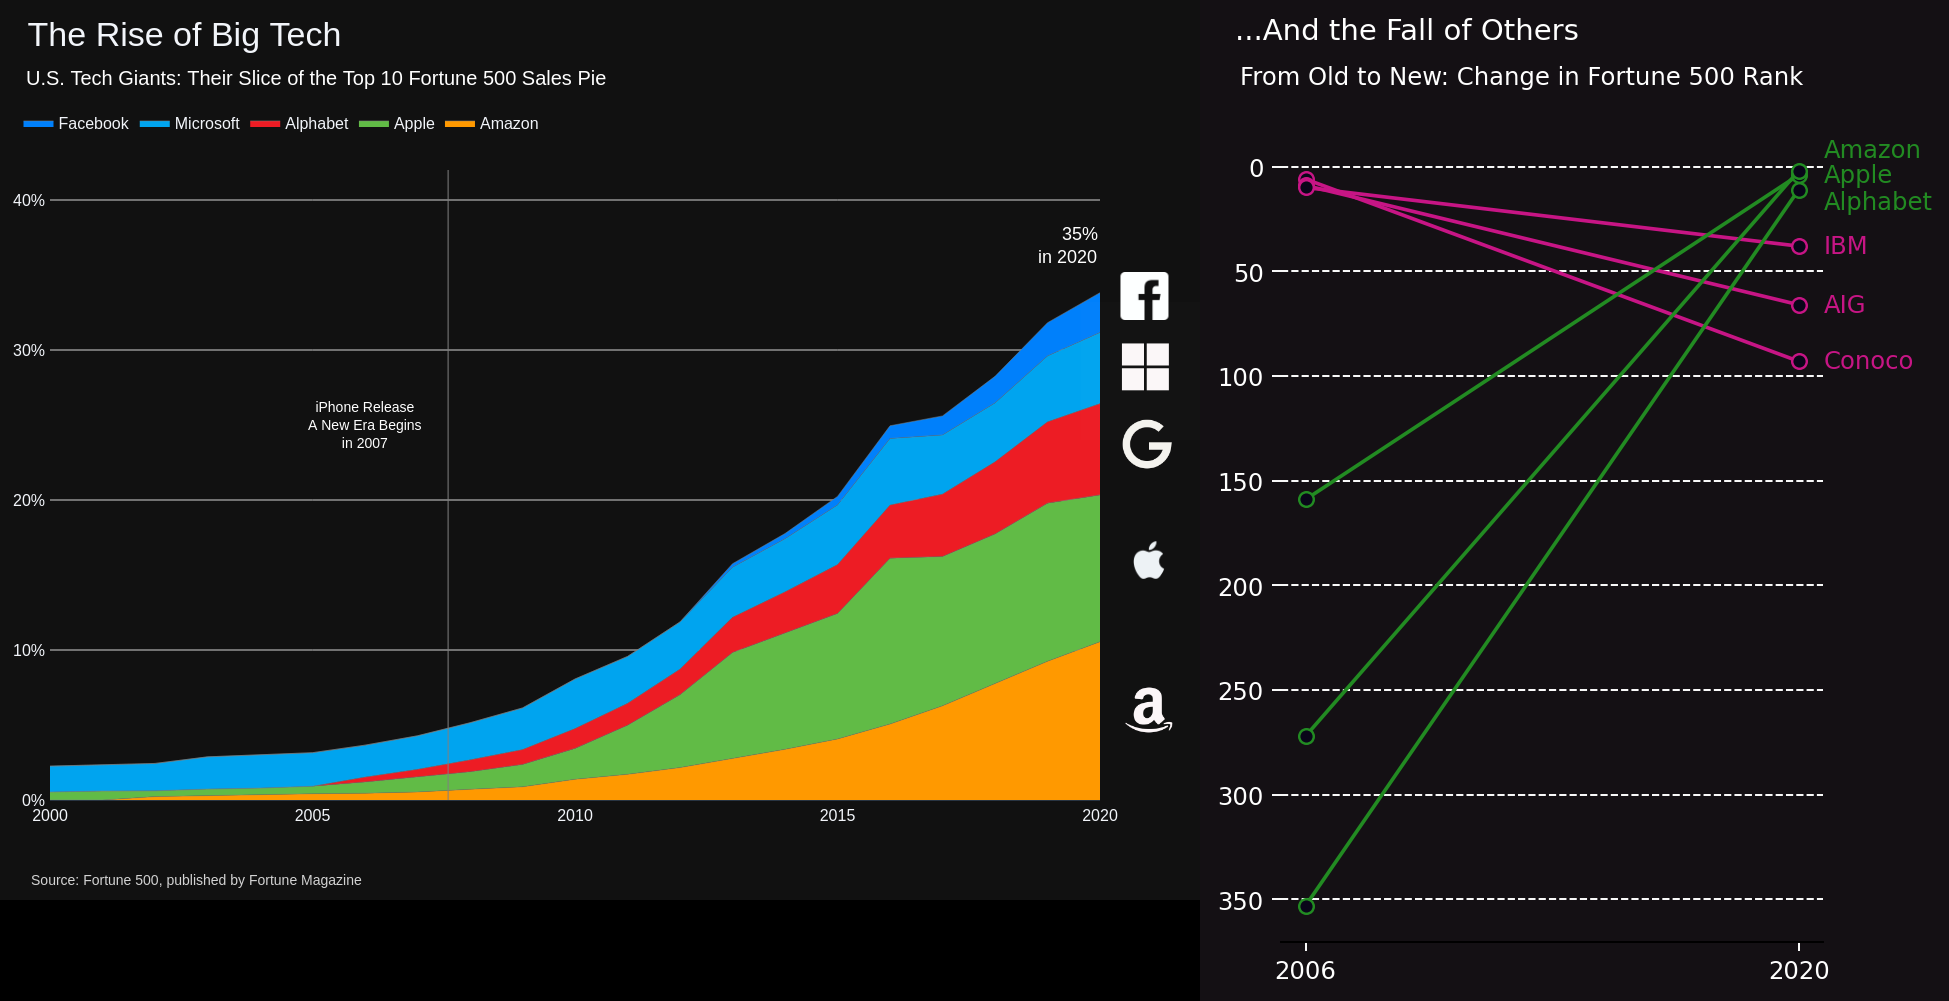

In [10]:
combined_image